# Custom CNN for HER2 IHC Image Classification
## Info
### Version: V2.1.0
#### Changes:
Updated Dataset!

In [20]:
# Version information
version_info = """
Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky
"""

In [21]:
# Write to version.txt
with open("/kaggle/working/version.txt", "w") as f:
    f.write(version_info)

# Check the content by reading it back
with open("/kaggle/working/version.txt", "r") as f:
    print(f.read())


Project Version: 2.1.0
Release Date: 2025-01-15
Author: Saky



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import shap
from keras.preprocessing import image
import tensorflow.keras.backend as K

In [4]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is enabled!")
else:
    print("GPU is not enabled.")

GPU is enabled!


In [5]:
# Path to your dataset
train_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/train/train"
test_dir = "/kaggle/input/her2-breast-cancer-detection-dataset/test/test"

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,               # Normalize pixel values
    rotation_range=40,               # Random rotations
    width_shift_range=0.2,           # Random horizontal shifts
    height_shift_range=0.2,          # Random vertical shifts
    shear_range=0.2,                 # Random shear
    zoom_range=0.2,                  # Random zoom
    horizontal_flip=True,            # Random horizontal flip
    fill_mode='nearest'              # Fill missing pixels
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',        # Use categorical for multi-class classification
    shuffle=False
)


Found 8797 images belonging to 4 classes.
Found 2200 images belonging to 4 classes.


In [6]:
def build_custom_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Convolutional Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))
    
    # Flatten and Dense Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout layer to reduce overfitting
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build and summarize the model
model = build_custom_cnn()
model.summary()

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,265,348 (73.49 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

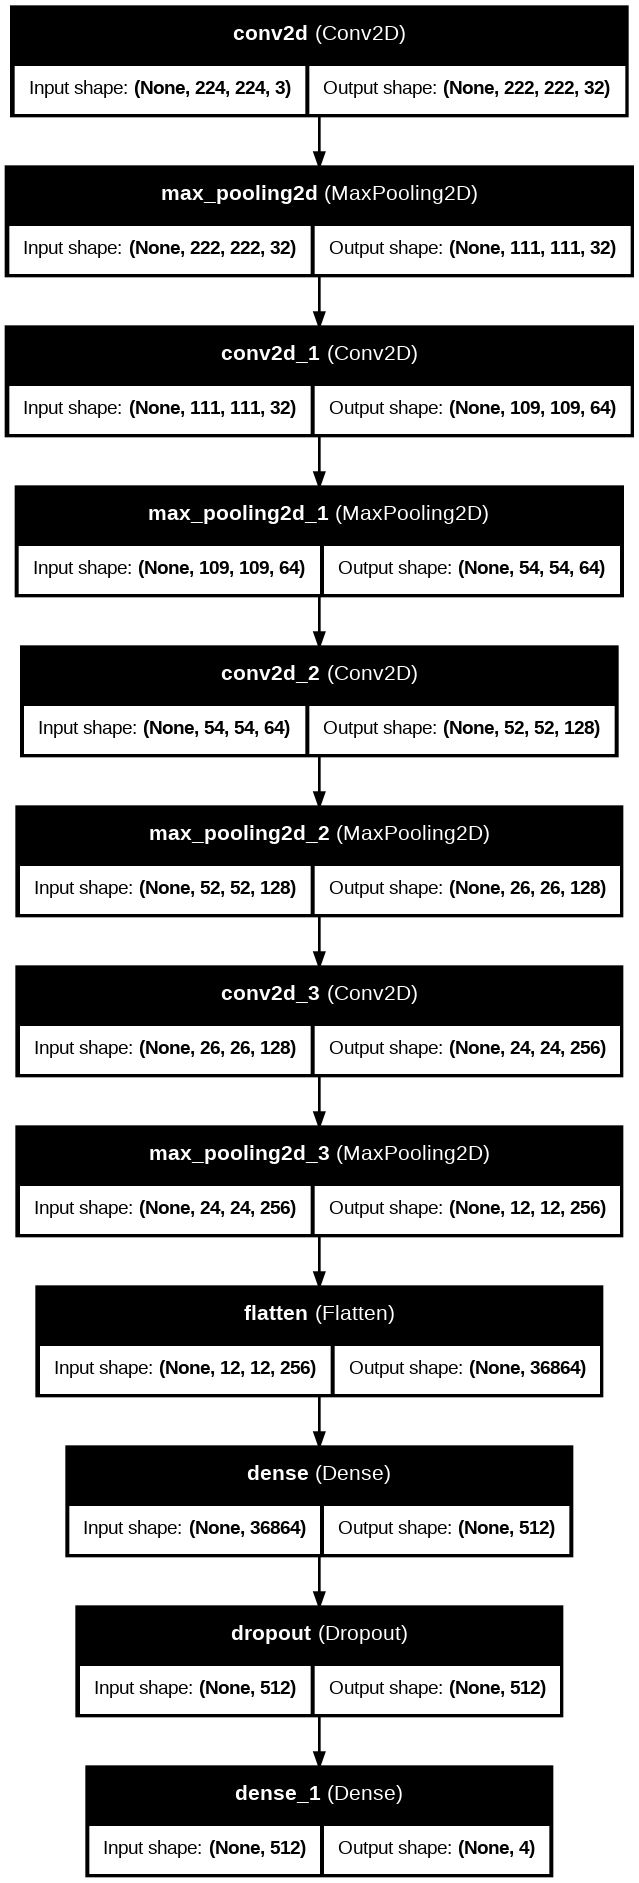

In [7]:
from tensorflow.keras.utils import plot_model

# Save the model diagram as an image file
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,  # Show input/output shapes of each layer
    show_layer_names=True,  # Show layer names
    dpi=96  # Adjust DPI for better quality
)

# If you're using a notebook, you can display the image directly
from IPython.display import Image
Image('model_architecture.png')

In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust epochs based on dataset size and performance
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


274/274 ━━━━━━━━━━━━━━━━━━━━ 191s 659ms/step - accuracy: 0.5973 - loss: 0.8197 - val_accuracy: 0.8598 - val_loss: 0.4157
Epoch 2/50
  1/274 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8125 - loss: 0.5117

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8125 - loss: 0.5117 - val_accuracy: 1.0000 - val_loss: 1.7782e-06
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 141s 503ms/step - accuracy: 0.7862 - loss: 0.4886 - val_accuracy: 0.8244 - val_loss: 0.4110
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.8750 - loss: 0.3199 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 500ms/step - accuracy: 0.8373 - loss: 0.3972 - val_accuracy: 0.8594 - val_loss: 0.3411
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6875 - loss: 0.4780 - val_accuracy: 1.0000 - val_loss: 4.9671e-09
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 140s 499ms/step - accuracy: 0.8421 - loss: 0.3770 - val_accuracy: 0.8704 - val_loss: 0.3278
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9375 - loss: 0.1483 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 138s 494ms/step - accuracy: 0.8557 - loss

In [9]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc*100:.2f}%")

68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.8961 - loss: 0.2615
Test accuracy: 90.62%


# Prediction and Generating Reports

In [10]:
# Generate predictions for the validation or test set
predictions = model.predict(test_generator)  # Ensure you use the correct generator
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve true labels from the generator
true_classes = test_generator.classes  # Ensure you use the same generator as in the prediction step

# Check the number of samples in true and predicted classes
print(f"Number of true labels: {len(true_classes)}")
print(f"Number of predicted labels: {len(predicted_classes)}")

# Ensure the lengths match
if len(true_classes) != len(predicted_classes):
    raise ValueError("Mismatch in number of true and predicted samples. Check the generator settings.")

# Get the class indices to use target names in the report
target_names = list(test_generator.class_indices.keys())

# Generate the classification report
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=target_names))

69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step
Number of true labels: 2200
Number of predicted labels: 2200
              precision    recall  f1-score   support

     class_0       0.92      0.90      0.91       758
    class_1+       0.85      0.79      0.82       538
    class_2+       0.78      0.94      0.85       226
    class_3+       0.99      0.99      0.99       678

    accuracy                           0.91      2200
   macro avg       0.88      0.91      0.89      2200
weighted avg       0.91      0.91      0.91      2200



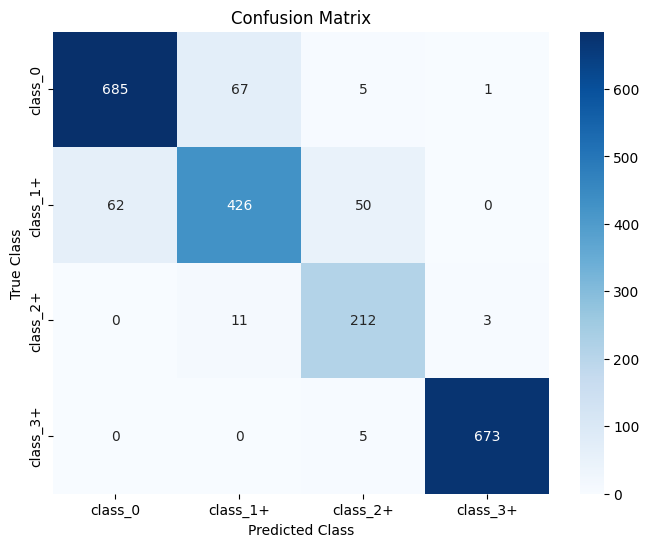

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

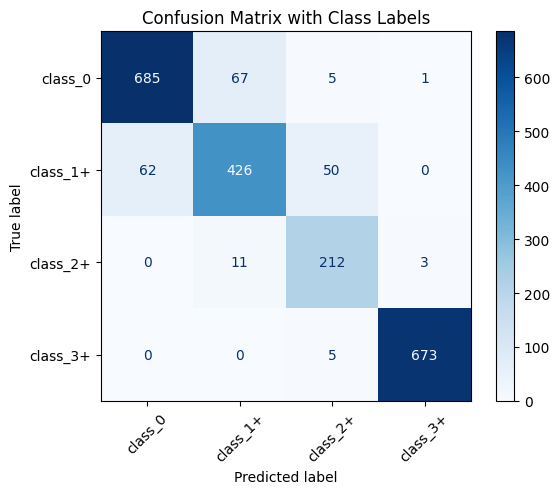

In [12]:
# Optional: Use sklearn's built-in confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix with Class Labels")
plt.show()

In [13]:
# Specify the path where you want to save the model
model_save_path = "/kaggle/working/custom_cnn_model_updated.h5"  # Use .h5 for HDF5 format or .tf for TensorFlow SavedModel format

# Save the trained model
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/custom_cnn_model_updated.h5


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,796,046 (220.47 MB)

 Trainable params: 19,265,348 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,530,698 (146.98 MB)

In [15]:
for layer in model.layers:
    print(layer.name)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
flatten
dense
dropout
dense_1


In [16]:
print(model.input_shape)  # Expected input shape for the model

(None, 224, 224, 3)


## Explanable AI with Lime

In [17]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from PIL import Image

def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    
    # Resize the image to the target size
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # If the image has only 1 channel (grayscale), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to RGB by stacking
    elif img_array.shape[-1] == 4:  # RGBA image (has alpha channel)
        img_array = img_array[..., :3]  # Remove the alpha channel
    
    # Ensure the image is in RGB format
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Preprocess the image (for MobileNetV2 model, you can use preprocess_input)
    img_array = preprocess_input(img_array)
    
    return img_array

# Use the preprocess_image function before passing the image to the model
image_path = '/kaggle/input/train-pvt-intnsty/class_2+/her2-2+-score_test_09.png'  # Replace with your actual image path
preprocessed_image = preprocess_image(image_path)

# Now, you can pass the preprocessed image to your model
prediction = model.predict(preprocessed_image)
print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
[[5.7628104e-11 1.0308919e-03 6.6862282e-05 9.9890232e-01]]


In [18]:
predicted_class = np.argmax(prediction)
print(predicted_class)  # This will give the index of the class with the highest probability

3


In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    
    # Resize the image to the target size
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # If the image has only 1 channel (grayscale), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.stack([img_array] * 3, axis=-1)  # Convert to RGB by stacking
    elif img_array.shape[-1] == 4:  # RGBA image (has alpha channel)
        img_array = img_array[..., :3]  # Remove the alpha channel
    
    # Ensure the image is in RGB format
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Preprocess the image (for MobileNetV2 model, you can use preprocess_input)
    img_array = preprocess_input(img_array)
    
    return img_array

# Load the model (replace with the actual path to your model)
model = load_model('/kaggle/working/custom_cnn_model_updated.h5')  # Ensure you load the correct model

# List of class names (update this with your actual class names)
class_names = ['class_0', 'class_1', 'class_2']  # Modify based on your classes

# Path to the image you want to classify
image_path = '/kaggle/input/train-pvt-intnsty/class_2+/her2-2+-score_test_09.png'  # Replace with your actual image path

# Preprocess the image before passing it to the model
preprocessed_image = preprocess_image(image_path)

# Make a prediction using the model
prediction = model.predict(preprocessed_image)

# Print the raw prediction probabilities
print("Prediction probabilities:", prediction)

# Find the index of the class with the highest probability
class_index = np.argmax(prediction, axis=-1)

# Ensure the class index is within bounds of class_names
if class_index[0] < len(class_names):
    predicted_class = class_names[class_index[0]]
    print(f"Predicted class label: {predicted_class}")
else:
    print("Class index is out of range. Check the model's output.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Prediction probabilities: [[5.7628104e-11 1.0308919e-03 6.6862282e-05 9.9890232e-01]]
Class index is out of range. Check the model's output.
